# 컨볼루션 신경망 모델 만들기 
1. 문제 정의하기
2. 데이터 준비하기
3. 데이터셋 생성하기
4. 모델 구성하기
5. 모델 학습과정 설정하기
6. 모델 학습시키기
7. 모델 평가하기

## 1. 문제 정의하기
* 문제 형태 : 다중 클래스 분류
* 입력 : 손으로 그린 삼각형, 사각형, 원 이미지
* 출력 : 삼각형, 사각형, 원일 확률을 나타내는 벡터

### 1.1 필요한 패키지 불러오기 

In [1]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 랜덤시드 고정시키기
np.random.seed(3)

## 2 데이터셋 생성하기
ImageDataGenerator 클래스를 이용하여 객체를 생성한 뒤 flow_from_directory() 함수를 호출하여 제네레이터(generator)를 생성합니다. flow_from_directory() 함수의 주요인자는 다음과 같습니다.

* 첫번재 인자 : 이미지 경로를 지정합니다.
* target_size : 패치 이미지 크기를 지정합니다. 폴더에 있는 원본 이미지 크기가 다르더라도 target_size에 지정된 크기로 자동 조절됩니다.
* batch_size : 배치 크기를 지정합니다.
* class_mode : 분류 방식에 대해서 지정합니다.
    * categorical : 2D one-hot 부호화된 라벨이 반환됩니다.
    * binary : 1D 이진 라벨이 반환됩니다.
    * sparse : 1D 정수 라벨이 반환됩니다.
    * None : 라벨이 반환되지 않습니다.

In [2]:
train_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
        './train',
        target_size=(24, 24),
        batch_size=3,
        class_mode='categorical')

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
        './test',
        target_size=(24, 24),    
        batch_size=3,
        class_mode='categorical')

Found 45 images belonging to 3 classes.
Found 15 images belonging to 3 classes.


## 3. 모델 구성하기
영상 분류에 높은 성능을 보이고 있는 컨볼루션 신경망 모델을 구성해보겠습니다. 

* 컨볼루션 레이어 : 입력 이미지 크기 24 x 24, 입력 이미지 채널 3개, 필터 크기 3 x 3, 필터 수 32개, 활성화 함수 ‘relu’
* 컨볼루션 레이어 : 필터 크기 3 x 3, 필터 수 64개, 활성화 함수 ‘relu’
* 맥스풀링 레이어 : 풀 크기 2 x 2
* 플래튼 레이어
* 댄스 레이어 : 출력 뉴런 수 128개, 활성화 함수 ‘relu’
* 댄스 레이어 : 출력 뉴런 수 3개, 활성화 함수 ‘softmax’

In [3]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(24,24,3)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(3, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 22, 22, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 20, 20, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 10, 10, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 6400)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               819328    
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 387       
Total params: 839,107
Trainable params: 839,107
Non-trainable params: 0
__________________________________________________

## 4. 모델 구성 확인

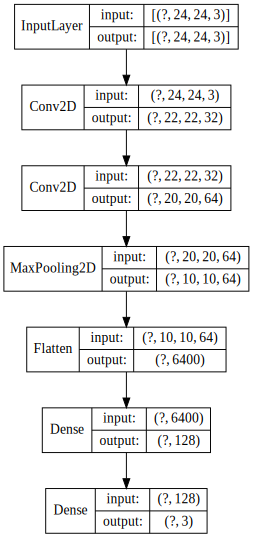

In [4]:
from IPython.display import SVG, display
from tensorflow.keras.utils import model_to_dot
from tensorflow.keras.utils import plot_model
import os

os.environ["PATH"] += os.pathsep + "C:/Program Files (x86)/Graphviz2.38/bin"

%matplotlib inline

iv1_dot = model_to_dot(model, show_shapes=True, show_layer_names=False, dpi=70)   # 사이즈 변경하기 
plot_model(model, to_file='model.png')
display(SVG(iv1_dot.create(prog=['dot'], format='svg')))

## 5. 모델 학습과정 설정하기
모델을 정의했다면 모델을 손실함수와 최적화 알고리즘으로 엮어봅니다.

* loss : 현재 가중치 세트를 평가하는 데 사용한 손실 함수 입니다. 다중 클래스 문제이므로 ‘categorical_crossentropy’으로 지정합니다.
* optimizer : 최적의 가중치를 검색하는 데 사용되는 최적화 알고리즘으로 효율적인 경사 하강법 알고리즘 중 하나인 ‘adam’을 사용합니다.
* metrics : 평가 척도를 나타내며 분류 문제에서는 일반적으로 ‘accuracy’으로 지정합니다.

In [5]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

## 6. 모델 학습시키기 
케라스에서는 모델을 학습시킬 때 주로 fit() 함수를 사용하지만 제네레이터로 생성된 배치로 학습시킬 경우에는 fit_generator() 함수를 사용합니다.
ImageDataGenerator라는 제네레이터로 이미지를 담고 있는 배치로 학습시키기 때문에 fit_generator() 함수를 사용

* 첫번째 인자 : 훈련데이터셋을 제공할 제네레이터를 지정합니다. 앞서 생성한 train_generator으로 지정합니다.
* steps_per_epoch : 한 epoch에 사용한 스텝 수를 지정합니다. 총 45개의 훈련 샘플이 있고 배치사이즈가 3이므로 15 스텝으로 지정합니다.
* epochs : 전체 훈련 데이터셋에 대해 학습 반복 횟수를 지정합니다. 50번을 반복적으로 학습시켜 보겠습니다.
* validation_data : 검증데이터셋을 제공할 제네레이터를 지정합니다. 본 예제에서는 앞서 생성한 validation_generator으로 지정합니다.
* validation_steps : 한 epoch 종료 시 마다 검증할 때 사용되는 검증 스텝 수를 지정합니다. 홍 15개의 검증 샘플이 있고 배치사이즈가 3이므로 5 스텝으로 지정합니다.

In [6]:
model.fit(
    train_generator,
    steps_per_epoch=15,
    epochs=50,
    validation_data=test_generator,
    validation_steps=5)

Epoch 1/50
15/15 [==============================] - 0s 19ms/step - loss: 0.9675 - accuracy: 0.4667 - val_loss: 0.5300 - val_accuracy: 1.0000
Epoch 2/50
15/15 [==============================] - 0s 9ms/step - loss: 0.2579 - accuracy: 0.9333 - val_loss: 0.3215 - val_accuracy: 0.9333
Epoch 3/50
15/15 [==============================] - 0s 9ms/step - loss: 0.0462 - accuracy: 1.0000 - val_loss: 0.0105 - val_accuracy: 1.0000
Epoch 4/50
15/15 [==============================] - 0s 9ms/step - loss: 0.0236 - accuracy: 1.0000 - val_loss: 0.0970 - val_accuracy: 1.0000
Epoch 5/50
15/15 [==============================] - 0s 9ms/step - loss: 0.0031 - accuracy: 1.0000 - val_loss: 0.0156 - val_accuracy: 1.0000
Epoch 6/50
15/15 [==============================] - 0s 9ms/step - loss: 8.5343e-04 - accuracy: 1.0000 - val_loss: 0.0284 - val_accuracy: 1.0000
Epoch 7/50
15/15 [==============================] - 0s 9ms/step - loss: 5.2980e-04 - accuracy: 1.0000 - val_loss: 0.0331 - val_accuracy: 1.0000
Epoch 8/50


## 7. 모델 평가하기 

In [7]:
print("-- Evaluate --")
scores = model.evaluate(test_generator, steps=5)
print("%s: %.2f%%" %(model.metrics_names[1], scores[1]*100))

-- Evaluate --
5/5 [==============================] - 0s 2ms/step - loss: 0.0155 - accuracy: 1.0000
accuracy: 100.00%


## 8. 모델 사용하기

In [8]:
print("-- Predict --")
output = model.predict(test_generator, steps=5)
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})
print(test_generator.class_indices)
print(output)

-- Predict --
{'circle': 0, 'rectangle': 1, 'triangle': 2}
[[0.000 0.000 1.000]
 [0.000 0.000 1.000]
 [0.989 0.000 0.011]
 [0.000 0.000 1.000]
 [1.000 0.000 0.000]
 [0.000 0.000 1.000]
 [0.000 1.000 0.000]
 [1.000 0.000 0.000]
 [1.000 0.000 0.000]
 [0.000 0.001 0.999]
 [0.074 0.802 0.124]
 [0.000 1.000 0.000]
 [0.074 0.802 0.124]
 [1.000 0.000 0.000]
 [1.000 0.000 0.000]]
